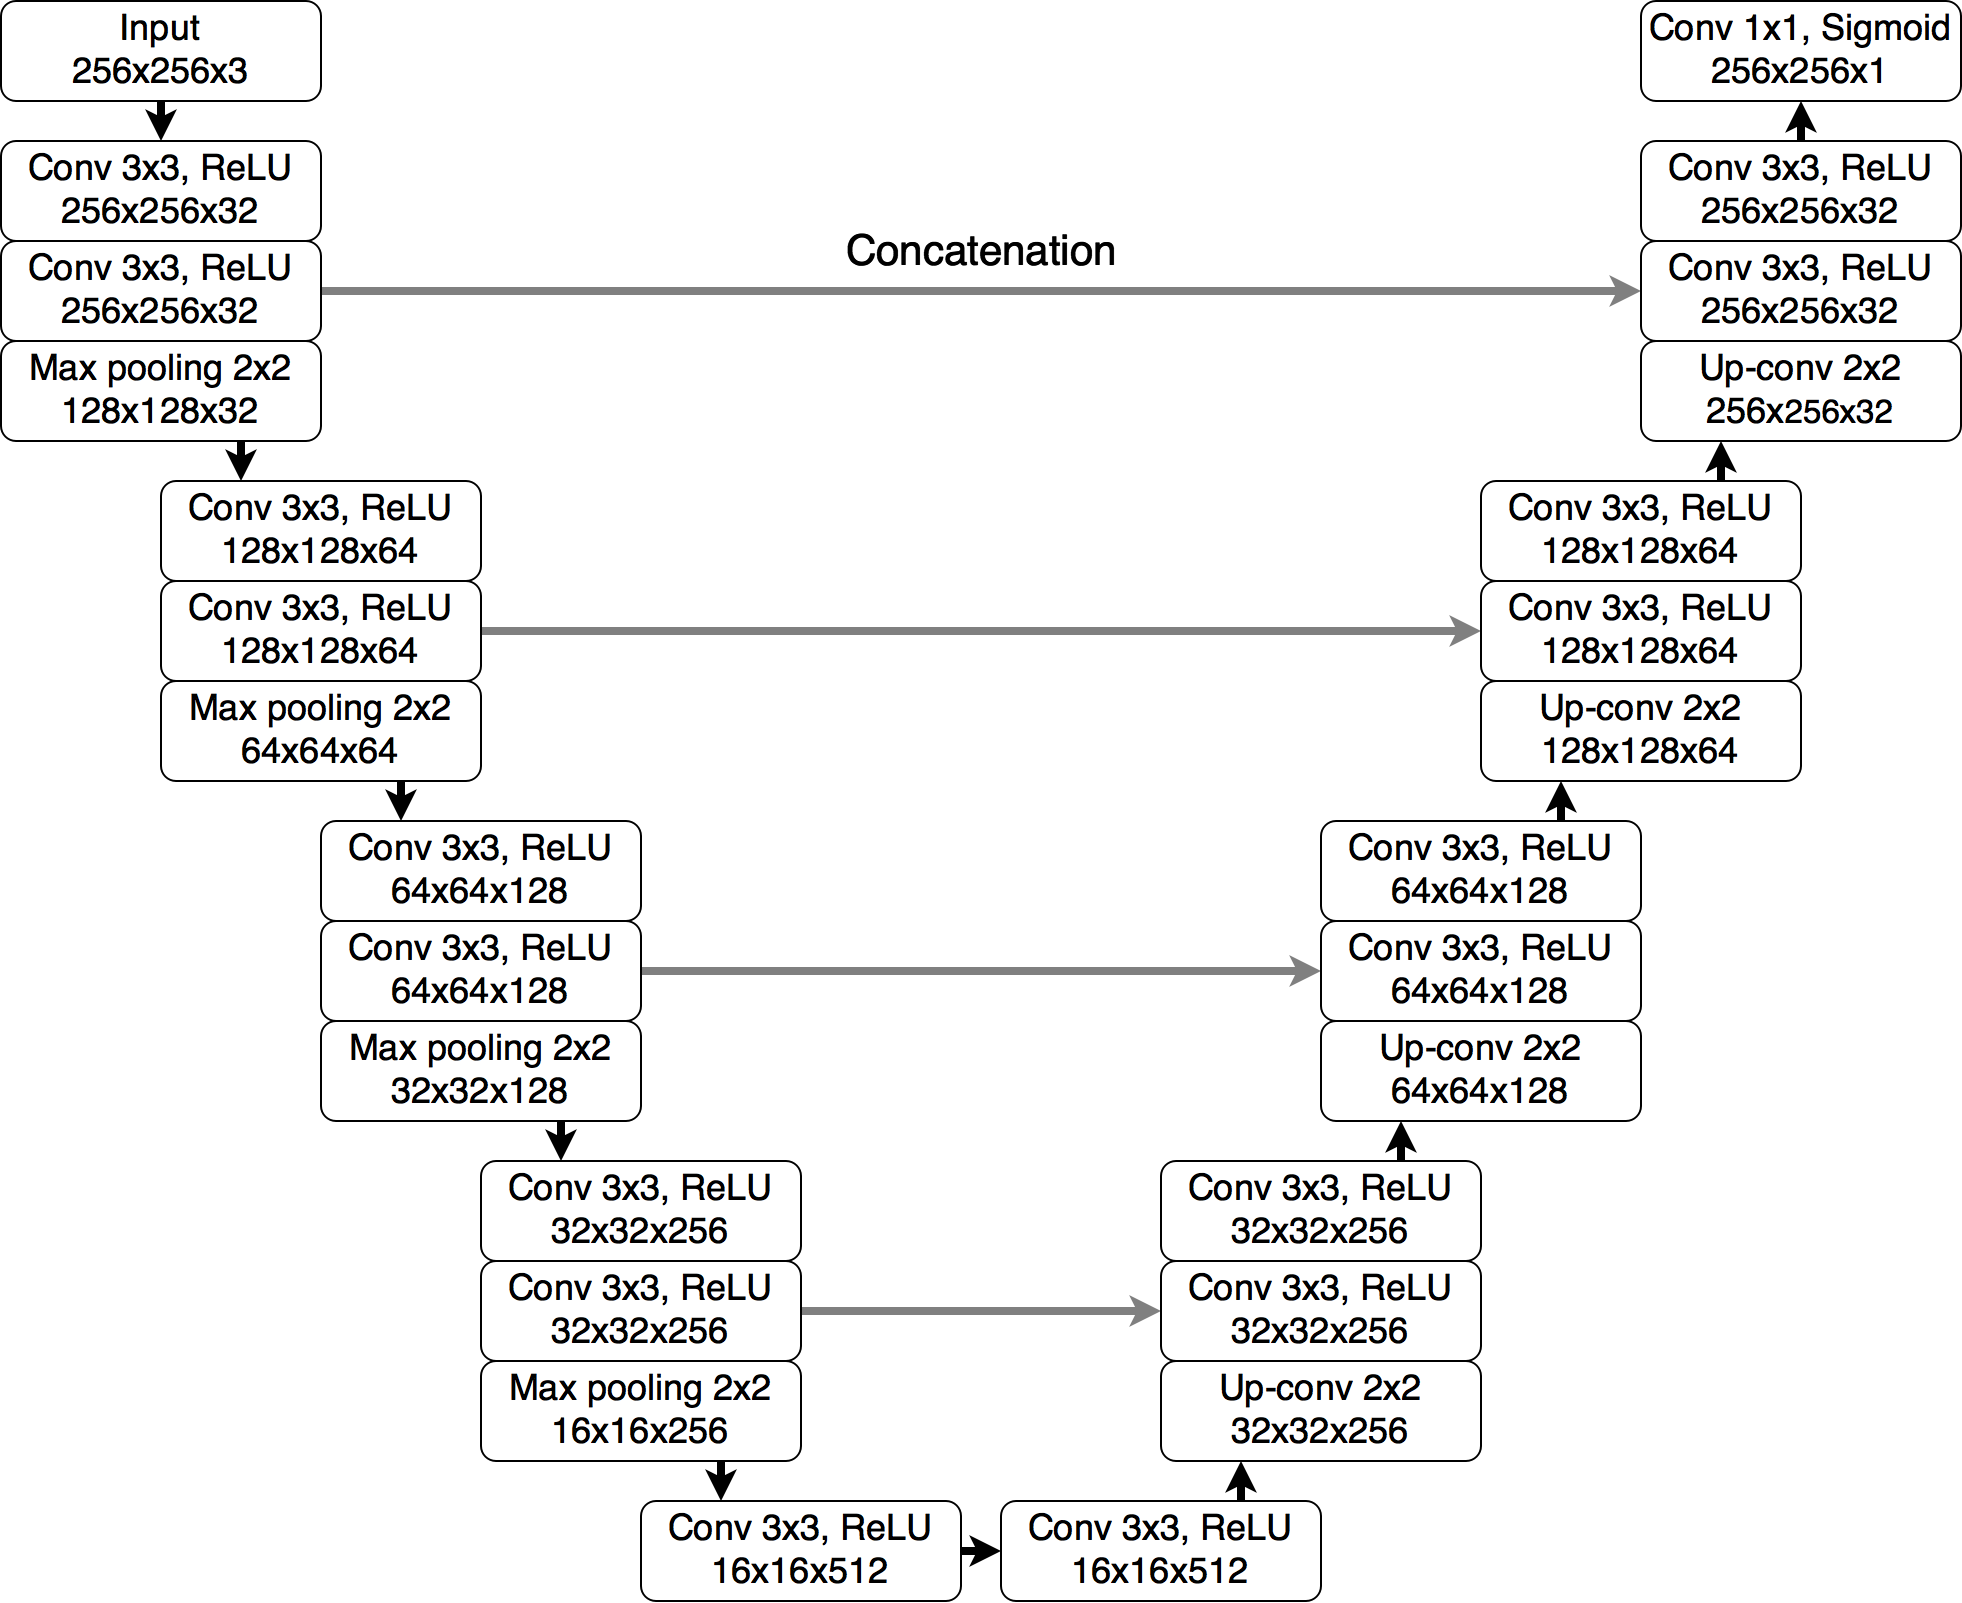
<br>
https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

In [1]:
import torch 
import torch.nn as nn

In [2]:
class UNET(nn.Module):
    def __init__(self, image_channels=3, num_classes=1):
        super(UNET, self).__init__()
        self.out_channels = 32
        self.num_classes = num_classes
        self.in_channels = image_channels
        self.down = self.downConv()
        self.bottle = self.bottleNeck()
        self.up = self.upConv()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        skip_connections = []
        
        # Encoder/Down Part 
        for layer in self.down:
            x = layer(x)
            skip_connections.append(x)
            x = self.pool(x)
        skip_connections = skip_connections[::-1] # reversed!
        
        # Bottleneck 
        x = self.bottle(x)
        
        # Decode/Up Part
        for i, layer in enumerate(self.up):
            x = layer(x)
            if i%2 == 0:
                x += skip_connections[i//2] 
        # del skip_connections
        return x
    
    def downConv(self):
        layers = nn.ModuleList()
        for _ in range(4):
            sub_layers = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.out_channels),
                nn.LeakyReLU(inplace=True),
            )
            self.in_channels = self.out_channels
            self.out_channels += self.out_channels
            layers.append(sub_layers)
        return layers
    
    def bottleNeck(self):
        layers = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(self.out_channels),
            nn.LeakyReLU(inplace=True)
        )
        self.in_channels = self.out_channels
        return layers
    
    def upConv(self):
        layers = nn.ModuleList()
        for i in range(3):
            self.out_channels = self.out_channels//2
            layers.append(nn.ConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=4, stride=2, padding=1))
            layer = nn.Sequential(
                nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.out_channels),
                nn.LeakyReLU(inplace=True),
            )
            layers.append(layer)
            self.in_channels = self.out_channels
        
        self.out_channels = self.out_channels//2
        layers.append(nn.ConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=4, stride=2, padding=1))
        layer = nn.Sequential(
                nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(self.out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(in_channels=self.out_channels, out_channels=self.num_classes, kernel_size=3, stride=1, padding=1, bias=True),
        )
        layers.append(layer)
        return layers
        

In [3]:
model = UNET(image_channels=3, num_classes=1).cuda()

In [4]:
images = torch.randn((90, 3, 256, 256))

In [5]:
from torch.utils.data import Dataset, DataLoader



class dataset(Dataset):
    def __init__(self, images):
        self.images = images
        
        
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        return self.images[idx]

    
data = dataset(images)
loader = DataLoader(data, batch_size=20, shuffle=False)

In [6]:
def test(model):
    for i in range(3):
        for images in loader:
            images = images.cuda()
            preds = model(images).detach().cpu()
            print(preds.shape)
        print(i)
test(model)

torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
0
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
1
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
2


In [5]:
torch_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).cuda()

Using cache found in C:\Users\yerda/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [6]:
test(torch_model)

torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
0
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
1
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([20, 1, 256, 256])
torch.Size([10, 1, 256, 256])
2


### Conclusion
<ul>
    <li>Equal memory usage across models</li>
    <li>Comparatively our model is optimal for training about<b> 700 mb </b></li> 
</ul>

In [18]:
torch_model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
model

UNET(
  (down): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )